# Predictions on sampled parameters

In this notebook we sample parameters as described in the report. We inspect how much generated parameters differ from the tuned parameters. After that we make predictions with generated parameters, compute scores and observe interesting results.

In [0]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import time
from scipy.linalg import funm
import numpy as np
from scipy.sparse.linalg import LinearOperator as ScipyLinearOperator
import scipy.sparse as sps
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils import data

Implementation of core algorithms of our approach

In [0]:
# ---------------------------------- Hessian-vector product operator----------------------------------
class Operator():
    def __init__(self, size):
        self._size = size

    def apply(self, vec):
        raise NotImplementedError()

    def __matmul__(self, vec):
        return self.apply(vec)

    def size(self):
        return self._size


class ModelHessianOperator(Operator):
    def __init__(self, model, criterion, data_input, data_target):
        size = int(sum(p.numel() for p in model.parameters()))
        super(ModelHessianOperator, self).__init__(size)
        self._model = model
        self._criterion = criterion
        self.set_model_data(data_input, data_target)

    def apply(self, vec):
        return to_vector(torch.autograd.grad(self._grad, self._model.parameters()
                                             , grad_outputs=vec, only_inputs=True, retain_graph=True))

    def set_model_data(self, data_input, data_target):
        self._data_input = data_input
        self._data_target = data_target
        self._output = self._model(self._data_input)
        self._loss = self._criterion(self._output, self._data_target)
        self._grad = to_vector(torch.autograd.grad(self._loss, self._model.parameters(), create_graph=True))

    def get_input(self):
        return self._data_input

    def get_target(self):
        return self._data_target


def to_vector(tensors):
    return torch.cat([t.contiguous().view(-1) for t in tensors])


# ----------------------------------- slq_upd.py -----------------------------------


def _lanczos_m_upd(A, m, matrix_shape, nv=1, rademacher=False, SV=None):
    orthtol = 1e-16

    if type(SV) != np.ndarray:
        if rademacher:
            # SV = np.sign(np.random.randn(A.shape[0], nv))
            SV = np.sign(np.random.randn(matrix_shape[0], nv))
        else:
            # SV = np.random.randn(A.shape[0], nv)  # init random vectors in columns: n x nv
            SV = np.random.randn(matrix_shape[0], nv)

    V = np.zeros((SV.shape[0], m, nv))
    T = np.zeros((nv, m, m))

    np.divide(SV, np.linalg.norm(SV, axis=0), out=SV)  # normalize each column
    V[:, 0, :] = SV


    w = A.matvec(SV.squeeze())
    w = w.reshape(-1,1)
    alpha = np.einsum('ij,ij->j', w, SV)
    w -= alpha[None, :] * SV
    beta = np.einsum('ij,ij->j', w, w)
    np.sqrt(beta, beta)

    T[:, 0, 0] = alpha
    T[:, 0, 1] = beta
    T[:, 1, 0] = beta

    np.divide(w, beta[None, :], out=w)
    V[:, 1, :] = w
    t = np.zeros((m, nv))

    for i in range(1, m):
        SVold = V[:, i - 1, :]
        SV = V[:, i, :]

        w = A.dot(SV.squeeze())  # sparse @ dense
        w = w.reshape(-1, 1)
        w -= beta[None, :] * SVold  # n x nv
        np.einsum('ij,ij->j', w, SV, out=alpha)

        T[:, i, i] = alpha

        if i < m - 1:
            w -= alpha[None, :] * SV  # n x nv
            # reortho
            np.einsum('ijk,ik->jk', V, w, out=t)
            w -= np.einsum('ijk,jk->ik', V, t)
            np.einsum('ij,ij->j', w, w, out=beta)
            np.sqrt(beta, beta)
            np.divide(w, beta[None, :], out=w)

            T[:, i, i + 1] = beta
            T[:, i + 1, i] = beta

            # more reotho
            innerprod = np.einsum('ijk,ik->jk', V, w)
            reortho = False
            for _ in range(100):
                if (innerprod <= orthtol).sum():
                    reortho = True
                    break
                np.einsum('ijk,ik->jk', V, w, out=t)
                w -= np.einsum('ijk,jk->ik', V, t)
                np.divide(w, np.linalg.norm(w, axis=0)[None, :], out=w)
                innerprod = np.einsum('ijk,ik->jk', V, w)

            V[:, i + 1, :] = w

            if (np.abs(beta) > 1e-2).sum() == 0 or not reortho:
                break
    return T, V


# ------------------------------ lanczos_upd.py ------------------------------


def lanczos(
    operator,
    size,
    num_lanczos_vectors,
    use_gpu=False,
    start_vector=None
):
    shape = (size, size)


    def _scipy_apply(x):
        x = torch.from_numpy(x)
        if use_gpu:
            x = x.cuda()
        return operator.apply(x.float()).cpu().numpy()

    scipy_op = ScipyLinearOperator(shape, _scipy_apply)
    T, V = _lanczos_m_upd(A=scipy_op, m=num_lanczos_vectors, matrix_shape=shape, SV=start_vector)
    return T, V

Convert vector of weights to list of tensors corresponding to model parameters

In [0]:
def get_tensors(model, vec):
  tlist = torch.split(vec, [p.numel() for p in model.parameters()])
  tlist = tuple(t.view(*p.shape) for t, p in zip(tlist, model.parameters())) 
  return tlist


Put weights from vector vec into the model

In [0]:
def set_model_parameters(model, vec):
  vec = torch.tensor(vec)
  tlist = get_tensors(model, vec)
  with torch.no_grad():
      for param, new_param in zip(model.parameters(), tlist):
            param.copy_(new_param)

Generate model parameters according to our method

In [0]:
def generate_weights(model, criterion, data_input, data_target, weights_mle, arbitrary=False):
    
    n = weights_mle.shape[0]
    m = n // 2
    z = np.random.randn(n, 1)

    op = ModelHessianOperator(model, criterion, data_input, data_target)
    

    T, V = lanczos(operator=op, num_lanczos_vectors=m, size=n, use_gpu=False, start_vector=z)
    T = T.squeeze()
    V = V.squeeze()
    V = np.matrix(V)
        
    func = lambda x: x ** (-0.5)
    
    # make T positive definite
    w, U = np.linalg.eigh(T)
    c = 1e-10
    w[w < c] = c
    T = U @ np.diag(w) @ U.T
    
    e_1 = np.zeros((m, 1))
    e_1[0] = 1
    matvec = np.linalg.norm(z) * V @ funm(T, func) @ e_1
    if arbitrary:
      nr = np.linalg.norm(matvec)
      matvec = np.random.randn(n, 1)
      matvec /= np.linalg.norm(matvec)
      matvec *= nr
    return weights_mle[:, None] + (1 / np.sqrt(len(data_input))) * matvec

Generate dataset for binary classification and visualize it using dimensionality reduction (PCA)

In [0]:
X, y = make_classification(
    n_samples=5000, n_features=20, n_redundant=0,
    n_informative=20, n_classes=2, random_state=42,
    n_clusters_per_class=1
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

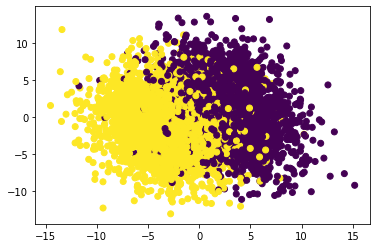

In [0]:
pca = PCA(n_components=2)
pca.fit(X)
rX = pca.transform(X)

plt.scatter(rX[:, 0], rX[:, 1], c=y)

In [0]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.labels = y
        self.vectors = X

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.vectors)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = self.vectors[index]
        y = self.labels[index]
        return X.astype(np.float32), torch.tensor(y)

Create dataset and dataset loaders. Define constants for learning procedure

In [0]:
batch_size = 200

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

n_iters = 1000
epochs = n_iters / (len(train_dataset) / batch_size)
input_dim = 20
output_dim = 2
lr_rate = 0.001

In [0]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

model = LogisticRegression(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

Train the model

In [0]:
iter_num = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter_num+=1
        if iter_num % 10==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}%.".format(iter_num, loss.item(), accuracy))

Iteration: 10. Loss: 0.9478456377983093. Accuracy: 51%.
Iteration: 20. Loss: 0.9732524156570435. Accuracy: 53%.
Iteration: 30. Loss: 0.9141009449958801. Accuracy: 54%.
Iteration: 40. Loss: 0.8587722182273865. Accuracy: 56%.
Iteration: 50. Loss: 0.9316371083259583. Accuracy: 58%.
Iteration: 60. Loss: 0.8157845139503479. Accuracy: 60%.
Iteration: 70. Loss: 0.7710672616958618. Accuracy: 62%.
Iteration: 80. Loss: 0.7960659265518188. Accuracy: 64%.
Iteration: 90. Loss: 0.652846097946167. Accuracy: 65%.
Iteration: 100. Loss: 0.6973274946212769. Accuracy: 67%.
Iteration: 110. Loss: 0.5791841149330139. Accuracy: 68%.
Iteration: 120. Loss: 0.7659718990325928. Accuracy: 69%.
Iteration: 130. Loss: 0.6368597149848938. Accuracy: 70%.
Iteration: 140. Loss: 0.5966109037399292. Accuracy: 72%.
Iteration: 150. Loss: 0.44504913687705994. Accuracy: 72%.
Iteration: 160. Loss: 0.5598639845848083. Accuracy: 74%.
Iteration: 170. Loss: 0.5676692724227905. Accuracy: 74%.
Iteration: 180. Loss: 0.5860525369644165

Tuned weights

In [0]:
weights_mle = to_vector(model.parameters()).detach().numpy()

Test dataset

In [0]:
test_batch = next(iter(test_loader))
data_input = test_batch[0]
data_target = test_batch[1]

In [0]:
# sampled vector of parameters can differ from the optimal significantly
sample = generate_weights(model, criterion, data_input, data_target, weights_mle)
print(np.linalg.norm(sample - weights_mle[:, None]) / np.linalg.norm(weights_mle))

271.50256972244813


Generate parameters, make predictions with these parameters and calculate loss and accuracy

In [0]:
def sample_scores(model, criterion, data_input, data_target, weights_mle, N_samples=10, arbitrary=False):
    loss = criterion(model(data_input), data_target)
    acc = []
    los = []
    for i in range(N_samples):
        sample_weights = generate_weights(model, criterion, data_input, data_target, weights_mle, arbitrary=arbitrary)
        set_model_parameters(model, sample_weights)
        loss = criterion(model(data_input), data_target)
        los.append(loss.item())
        total = 0
        correct = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            # for gpu, bring the predicted and labels back to cpu fro python operations to work
            correct+= (predicted == labels).sum()
        accuracy = 100. * correct / float(total)
        acc.append(accuracy)
        set_model_parameters(model, weights_mle)
    return acc, los

In [0]:
scores = sample_scores(model, criterion, data_input, data_target, weights_mle, N_samples=100)

Accuracy is concentrated around the value achieved on optimal parameters

(array([ 1.,  0.,  2.,  1., 11., 24., 27., 21.,  9.,  4.]),
 array([90.606064, 90.854546, 91.103035, 91.35152 , 91.600006, 91.84849 ,
        92.09697 , 92.34546 , 92.59394 , 92.84243 , 93.09091 ],
       dtype=float32),
 <a list of 10 Patch objects>)

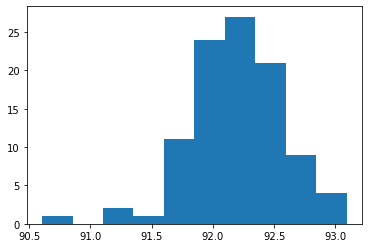

In [0]:
plt.hist(scores[0])
plt.xlabel('accuracy')
plt.ylabel('count')

Loss is concentrated around the value achieved on optimal parameters

(array([ 6., 15., 14., 23., 19., 12.,  9.,  1.,  0.,  1.]),
 array([0.19512764, 0.19826966, 0.20141168, 0.20455371, 0.20769573,
        0.21083775, 0.21397977, 0.2171218 , 0.22026382, 0.22340584,
        0.22654787]),
 <a list of 10 Patch objects>)

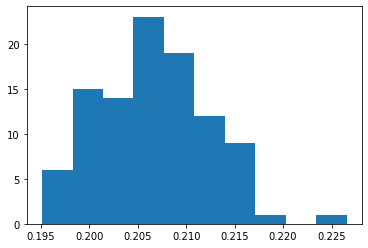

In [0]:
plt.hist(scores[1])
plt.xlabel('loss')
plt.ylabel('count')

**Despite the fact that generated parameters differ from the optimal ones dramatically, scores of predictions are almost the same**

Instead of sampling parameters according to our methods ($\theta = \theta_{MLE} + A^{-1/2}z,\ z \sim \mathcal{N}(0, I_n)$), below we will generate parameters as follows: $$\xi \sim \mathcal{N}(0, I_n),\ \xi := \frac{\xi}{||\xi||_2}||A^{-1/2}z||_2 $$
$$\theta = \theta_{MLE} + \xi$$
The deviation of these parameters from $\theta_{MLE}$ has the same norm, but notice how predictions fail horribly!

In [0]:
scores = sample_scores(model, criterion, data_input, data_target, weights_mle, N_samples=100, arbitrary=True)

(array([ 6.,  8.,  5., 16., 20., 17.,  9.,  9.,  4.,  6.]),
 array([26.666666, 31.563635, 36.460606, 41.357574, 46.254543, 51.151512,
        56.04848 , 60.945454, 65.84242 , 70.73939 , 75.63636 ],
       dtype=float32),
 <a list of 10 Patch objects>)

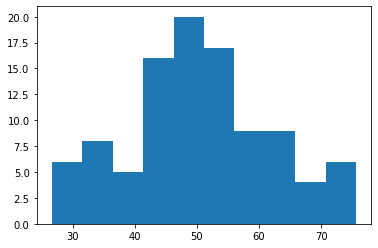

In [0]:
plt.hist(scores[0])
plt.xlabel('accuracy')
plt.ylabel('count')

(array([44.,  5., 10.,  9.,  8.,  6.,  4.,  3.,  9.,  2.]),
 array([   87.72843933,  1087.60725555,  2087.48607178,  3087.364888  ,
         4087.24370422,  5087.12252045,  6087.00133667,  7086.88015289,
         8086.75896912,  9086.63778534, 10086.51660156]),
 <a list of 10 Patch objects>)

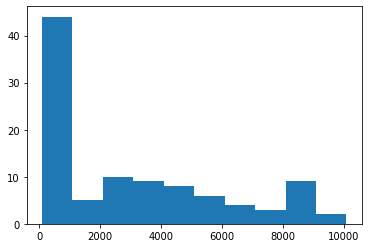

In [0]:
plt.hist(scores[1])
plt.xlabel('loss')
plt.ylabel('count')